# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.preprocessing import StandardScaler
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded 
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [5]:
# Identify missing or unknown data values and convert them to NaNs
for idx in range(len(feat_info)):
    column_info = feat_info.iloc[idx]
    
    # Grab the colname and the missing or unknown values for each column
    colname = column_info.attribute
    missing_or_unknown = column_info.missing_or_unknown
    
    # Evaluate them to convert from string to list 
    nan_list = missing_or_unknown.replace('[', '').replace(']', '').split(',')
    
    # print("{} has missing values stored as: {}".format(colname, nan_list))
    # Update the dataframe using the criteria for each column
    azdias[colname].replace(nan_list, np.NaN, inplace=True)

In [6]:
# Sum the null values by column
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe.

For the remaining features, are there any patterns in which columns have, or share, missing data?

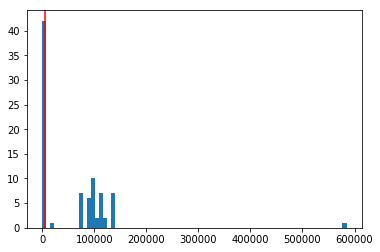

In [7]:
# Perform an assessment of how much missing data there is in each column of the dataset
missing_values = azdias.isnull().sum()
plt.hist(missing_values, bins = 75)

# Put vertical line at 5,000 as arbitrary threshold
plt.axvline(5000, c = 'red')
plt.show()

We can see that the majority of the columns are completely full and aren't missing any values. We have a cluster of columns where approximately 1/6 of observations are missing values and an outlier column that is missing a lot of values. 

In [8]:
missing_values[missing_values > 5000].sort_values()

HH_EINKOMMEN_SCORE      18348
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
WOHNDAUER_2008          73499
KONSUMNAEHE             73969
WOHNLAGE                93148
OST_WEST_KZ             93148
MIN_GEBAEUDEJAHR        93148
ANZ_HAUSHALTE_AKTIV     93148
GEBAEUDETYP             93148
GEBAEUDETYP_RASTER      93155
BALLRAUM                93740
INNENSTADT              93740
EWDICHTE                93740
ANZ_HH_TITEL            97008
ARBEIT                  97216
ORTSGR_KLS9             97216
RELAT_AB                97216
CAMEO_INTL_2015         99352
CAMEO_DEU_2015          99352
CAMEO_DEUG_2015         99352
KBA13_ANZAHL_PKW       105800
W_KEIT_KIND_HH         107602
PLZ8_GBZ               116515
PLZ8_HHZ               116515
PLZ8_BAUMAX            116515
PLZ8_ANTG4             116515
PLZ8_ANTG3             116515
PLZ8_ANTG1             116515
PLZ8_ANTG2             116515
REGIOTYP  

Looks like it is batches of data that weren't available for some observations. i.e. all those columns that are prefixed by 'PLZ8', or 'KBA05'. I investigate this below, and then more generally missing values by observation underneath that. We can also see here that `KK_KUNDENTYP` is the column that is missing lots of observations; perhaps this is because it adds additional information when another column is of a certain value and is thus only applicable for a small number of observations. 

In [9]:
feat_info[feat_info.attribute == 'KK_KUNDENTYP']

,attribute,information_level,type,missing_or_unknown
47,KK_KUNDENTYP,household,categorical,[-1]


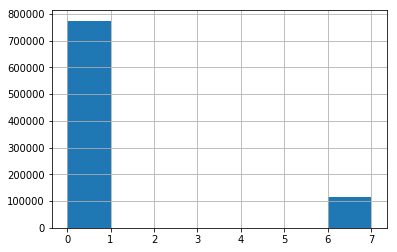

In [10]:
# Let's look further into the PLZ8 columns
plz8_colnames = [i for i in feat_info.attribute if i.startswith('PLZ8')]
azdias[plz8_colnames].isnull().sum(1).hist(bins = len(plz8_colnames))
plt.show()

This shows us that there are no observations that are missing some of the information contained within these files, either the information is available or it isn't, suggesting that perhaps the plz8 dataset is smaller than the overall base or that the final dataset is perhaps a combination of multiple sources of information; this could definitely be the case. 

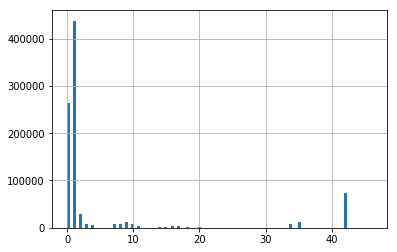

In [11]:
azdias.isnull().sum(1).hist(bins = 100)
plt.show()

Looks as though the majority of the records we have are missing less than 10 column values. While the highest we see is 42 missing values for a single observation. 

In [12]:
# Remove the outlier columns from the dataset
azdias_trimmed = azdias[missing_values[missing_values < 5000].keys()]
azdias_trimmed.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ONLINE_AFFINITAET
0,-1,2,1,2.0,3,4,3,5,5,3,...,4,7,6,6,5,3,-1,-1,3,1.0
1,-1,1,2,5.0,1,5,2,5,4,5,...,6,4,7,4,7,6,3,2,5,3.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,4,7,7,7,3,3,2,1,5,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,3,4,4,5,4,4,1,1,3,1.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2,3,2,2,4,2,2,2,4,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I think that the final dataset is a collection of smaller datasets, or has had some appended for which information regarding all the observations wasn't available. You can see that, by column, there tend to be groups of columns where all the information is missing for single observations; I showed this above when I looked into those columns that are prefixed with 'PLZ8'.

I removed columns that have more than 5000 missing values; this should leave those columns where the majority of the information is complete, and observations that have mostly available values which is going to help in the clustering and effectiveness of clustering those observations where information is commonly available. You don't want to grouping clusters based on a data value that is only available for 50% of the total population of the data. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on.

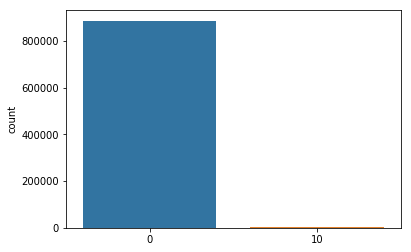

In [13]:
# How much data is missing in each row of the trimmed dataset?
sns.countplot(list(azdias_trimmed.isnull().sum(1)))
plt.show()

As you can see, the trimmed column dataset that we have created doesn't have many missing values, but those that are missing values are missing 10. Once again implying to me that the information is provided in batches and that a small number of observations here don't have that information avialable.   

Let's have a look at the full dataset, and split to see what we can compare by those that are missing lots of values, and those that are complete/fuller so that we are able to see whether the distirbution of values for each column differs when particular observations are missing more values across all columns. 

In [14]:
near_complete_idx = azdias.isnull().sum(1) <= 3
near_complete = azdias[near_complete_idx]
print(near_complete.shape)

remainder = azdias[-near_complete_idx]
print(remainder.shape)

# Sanity check to make sure that all records belong in one of the other datasets
print(azdias.shape)
print(near_complete.shape[0] + remainder.shape[0])

(738241, 85)
(152980, 85)
(891221, 85)
891221


Note that we don't have a perfect 50/50 split, but less than or equal to 3 missing values seemed like a good cut off point for 'completeness'. We won't be able to achieve that 50/50 split as a result of the distribution that we observed when we plotted how many observations were missing values.

In [15]:
def compare_columns(df1, df2, column):
    fig, ax = plt.subplots(ncols=2, nrows=1, sharex=False, sharey=False, figsize=(12,3))
    df1[column].hist(color='#2ecc71', ax = ax[0])
    df2[column].hist(color='#e74c3c', ax = ax[1])
    fig.suptitle(column)
    plt.show()

In [16]:
# Set random seed for reproducability
random.seed(a=1)
rand_cols = random.sample(list(azdias.columns), 5)

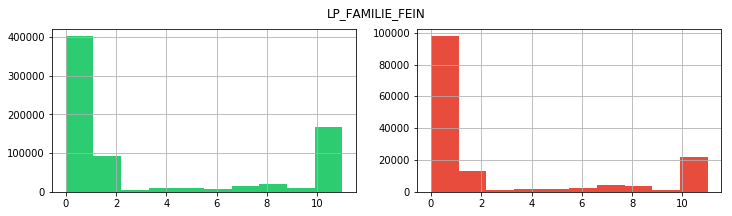

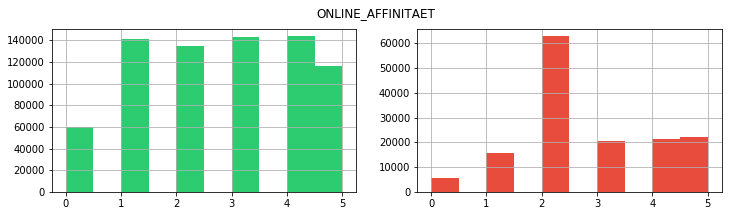

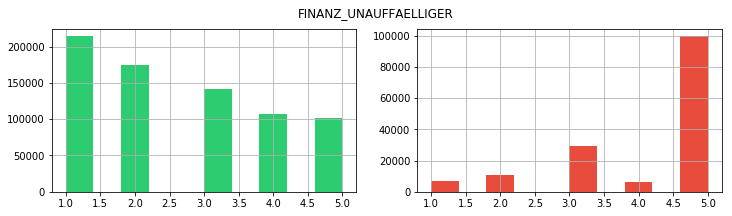

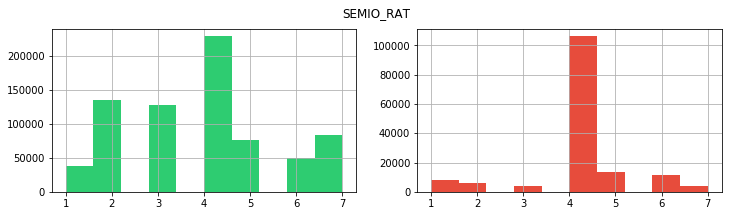

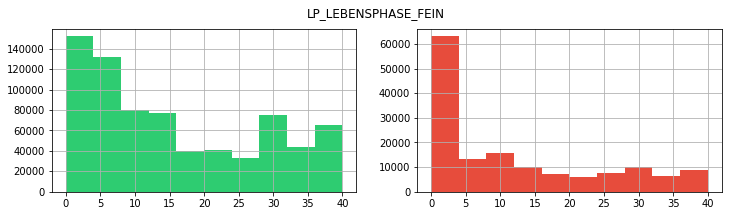

In [17]:
for col in rand_cols:
    compare_columns(near_complete, remainder, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

You can see that the distribution of values that we see for each of the 5 columns are similar across the datasets which are missing many columns, and the observations that are relatively complete in the dataset.  

The distribution with many missing values per observation has roughly the same distribution of values, and thus we can remove the observations with many missing values without causing any major issues to the dataset as a whole, and thus our clustering. There is no qualitative difference between these two datasets: observations with near complete information and observations that are missing more values (threshold = 3). 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

__Summary:__ *Numeric, interval and ordinal variables can remain as they are. Categorical and mixed must be handled.*

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

In [18]:
# How many features are there of each data type? Luckily feat_info contains this information
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

We can grab the type of each column from the `feat_info.type` column, and then simply get the values using `value_counts()`. 

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.  

For this we are going to want to loop through the columns and check their status, and if they are categorical, then we want to know whether they are binomial, or not and handle them appropriately. I think the best way to do this is to create a table with additional information on the columns that isn't already provided in the `feat_info` table. 

In [19]:
# Set the column name as the index, for ease of manipulation
feat_info.set_index('attribute', inplace = True)

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
d = {'column': [], 'type': [], 'distinct_values': [], 'n_distinct_values': []}
for col in near_complete.columns:
    if feat_info.loc[col].type == 'mixed':
        d['column'].append(col)
        d['type'].append(feat_info.loc[col].type)
        d['distinct_values'].append(near_complete[col].unique())
        d['n_distinct_values'].append(len(near_complete[col].unique()))
        
mixed_columns_df = pd.DataFrame.from_dict(d)
mixed_columns_df

,column,distinct_values,n_distinct_values,type
0,LP_LEBENSPHASE_FEIN,"[21.0, 3.0, 0.0, 32.0, 8.0, 2.0, 5.0, 10.0, 4....",41,mixed
1,LP_LEBENSPHASE_GROB,"[6.0, 1.0, 0.0, 10.0, 2.0, 3.0, 5.0, 7.0, 12.0...",13,mixed
2,PRAEGENDE_JUGENDJAHRE,"[14, 15, 8, 3, 10, 11, 9, 6, 4, 5, 0, 2, 1, 12...",16,mixed
3,WOHNLAGE,"[4.0, 2.0, 7.0, 3.0, 5.0, 1.0, 8.0, 0.0]",8,mixed
4,CAMEO_INTL_2015,"[51, 24, 12, 43, 54, 22, 14, 13, 15, 41, 34, 5...",22,mixed
5,KBA05_BAUMAX,"[5.0, 0.0, 1.0, 2.0, 3.0, 4.0]",6,mixed
6,PLZ8_BAUMAX,"[1.0, 2.0, 4.0, 5.0, 3.0]",5,mixed


We can see that we have 7 mixed columns here, and that they all have high numbers of distinct values. 

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
d = {'column': [], 'type': [], 'distinct_values': [], 'n_distinct_values': []}
for col in near_complete.columns:
    if feat_info.loc[col].type == 'categorical':
        d['column'].append(col)
        d['type'].append(feat_info.loc[col].type)
        d['distinct_values'].append(near_complete[col].unique())
        d['n_distinct_values'].append(len(near_complete[col].unique()))
        
categorical_columns_df = pd.DataFrame.from_dict(d)
categorical_columns_df

,column,distinct_values,n_distinct_values,type
0,AGER_TYP,"[-1, 2, 3, 0, 1]",5,categorical
1,ANREDE_KZ,"[2, 1]",2,categorical
2,CJT_GESAMTTYP,"[5.0, 3.0, 2.0, 4.0, 1.0, 6.0]",6,categorical
3,FINANZTYP,"[1, 6, 5, 2, 4, 3]",6,categorical
4,GFK_URLAUBERTYP,"[10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4....",12,categorical
5,GREEN_AVANTGARDE,"[0, 1]",2,categorical
6,LP_FAMILIE_FEIN,"[5.0, 1.0, 0.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0...",12,categorical
7,LP_FAMILIE_GROB,"[3.0, 1.0, 0.0, 5.0, 2.0, 4.0]",6,categorical
8,LP_STATUS_FEIN,"[2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 8.0, 5.0, 6.0,...",10,categorical
9,LP_STATUS_GROB,"[1.0, 2.0, 4.0, 5.0, 3.0]",5,categorical


In [22]:
multi_categories = categorical_columns_df[categorical_columns_df.n_distinct_values > 2]
multi_categories

,column,distinct_values,n_distinct_values,type
0,AGER_TYP,"[-1, 2, 3, 0, 1]",5,categorical
2,CJT_GESAMTTYP,"[5.0, 3.0, 2.0, 4.0, 1.0, 6.0]",6,categorical
3,FINANZTYP,"[1, 6, 5, 2, 4, 3]",6,categorical
4,GFK_URLAUBERTYP,"[10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4....",12,categorical
6,LP_FAMILIE_FEIN,"[5.0, 1.0, 0.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0...",12,categorical
7,LP_FAMILIE_GROB,"[3.0, 1.0, 0.0, 5.0, 2.0, 4.0]",6,categorical
8,LP_STATUS_FEIN,"[2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 8.0, 5.0, 6.0,...",10,categorical
9,LP_STATUS_GROB,"[1.0, 2.0, 4.0, 5.0, 3.0]",5,categorical
10,NATIONALITAET_KZ,"[1, 3, 2, 0]",4,categorical
11,SHOPPER_TYP,"[3, 2, 1, 0, -1]",5,categorical


In [23]:
binary_categories = categorical_columns_df[categorical_columns_df.n_distinct_values == 2]
binary_categories

,column,distinct_values,n_distinct_values,type
1,ANREDE_KZ,"[2, 1]",2,categorical
5,GREEN_AVANTGARDE,"[0, 1]",2,categorical
12,SOHO_KZ,"[1.0, 0.0]",2,categorical
18,OST_WEST_KZ,"[W, O]",2,categorical


Recode `OST_WEST_KZ` so it is numeric. 

#### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

In [24]:
def is_east(x):
    if x == 'O':
        return 1
    else: 
        return 0

near_complete['is_location_east'] = near_complete['OST_WEST_KZ'].apply(is_east)
near_complete.drop('OST_WEST_KZ', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
# Quick sanity check to make sure that we aren't losing any columns in this split
print(categorical_columns_df.shape[0])
print(binary_categories.shape[0])
print(multi_categories.shape[0])

21
4
17


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I loop through the categories that are multi-variate and drop each one from the dataset, just for ease and to avoid creating a large number of dimensions for clustering later.  

I will keep the binary categorical variables, and leave the mixed variables in the dataset until after the next data processing step where we are going to encode two of them to be able to use them in the analysis. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
# Use the complete set to view the category in full 
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 0, 14, 15,  8,  3, 10, 11,  5,  9,  6,  4,  2,  1, 12, 13,  7])

We can have a look at what this means through using the `Data_Dictionary.md` that is provided with the dataset:

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [27]:
# Define functions that split based on the criteria 
def is_mainstream(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1
    
def decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6

In [28]:
near_complete['is_mainstream'] = near_complete['PRAEGENDE_JUGENDJAHRE'].apply(is_mainstream)
near_complete['decade'] = near_complete['PRAEGENDE_JUGENDJAHRE'].apply(decade)
near_complete.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

Let's take a look at the second variable that we are going to encode using the `Data_Dictionary.md`: 'CAMEO_INTL_2015'

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Use the complete set to view the category in full 
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

We can encode new variables using user-defined functions as we did previously. 

In [30]:
# We can use floor division here 
def household(x):
    try: 
        value = int(x) // 10
        return value
    except ValueError:
        return np.nan
    
    if np.isnan(x):
        return x
    else:
        return int(x) // 10

# We can use the modulo here 
def life_status(x):
    try: 
        value = int(x) % 10
        return value
    except ValueError:
        return np.nan
    
    if np.isnan(x):
        return x
    else:
        return int(x) % 10

In [31]:
near_complete['household'] = near_complete['CAMEO_INTL_2015'].apply(household)
near_complete['life_status'] = near_complete['CAMEO_INTL_2015'].apply(life_status)
near_complete.drop('CAMEO_INTL_2015', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

When you are given the information, or encode the data yourself using defined boundaries afterwards it is a very easy way through the definition of user functions, as I have done above. It is interesting how variables such as `CAMEO_INTL_2015` are not split when they are collected, but that doesn't matter here. After they were encoded, it is redundant information so can be disregarded now that the two information classes are split and linearly spaced as numbers.  

I will drop the remainder of the mixed categories here for simplicity, but I would take a similar approach with other variables, and in feature engineering by leveraging `apply`. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained.

##### As a reminder, your data should only be from **the subset with few or no missing values**.
- - - -

In [32]:
# Do whatever you need to in order to ensure that the dataframe only contains 
# the columns that should be passed to the algorithm functions.

# Remove multi-categorical variables
for col in multi_categories.column:
    # Remove the multicategory columns from the data for ease - add ignore flag so that if they have already been removed it continues 
    near_complete.drop(col, axis=1, inplace=True, errors = 'ignore')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [33]:
# Remove all mixed variables now that we have encoded and removed 2 of them above
for col in mixed_columns_df.column:
    # Remove the mixed columns - add ignore flag so that if they have already been removed it continues 
    near_complete.drop(col, axis=1, inplace=True, errors = 'ignore')
    # Confirmation
    print('"{}" removed."'.format(col))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


"LP_LEBENSPHASE_FEIN" removed."
"LP_LEBENSPHASE_GROB" removed."
"PRAEGENDE_JUGENDJAHRE" removed."
"WOHNLAGE" removed."
"CAMEO_INTL_2015" removed."
"KBA05_BAUMAX" removed."
"PLZ8_BAUMAX" removed."


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

I will identify those columns that I want removed in the cleaning step by looking back at the initial selection for exploration and finding those columns that are predominantly missing across the dataset as a __whole__; this is why I am going to read in the datasets in their entirity again to make sure that I am using them as they would be provided in the first place. 

In [34]:
# Load in fresh sets of the data 
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [35]:
missing_values = azdias.isnull().sum()
cols_to_be_removed = list(missing_values[missing_values > 100000].keys())
print(cols_to_be_removed)
print('\nColumns to be removed: {}/{}'.format(len(cols_to_be_removed), azdias.shape[1]))

['KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']

Columns to be removed: 19/85


This will deplete the amount of information in the dataset significantly; basically we are halving the number of columns that we are working with. This might be a bit drastic, but we are looking to create a scaled dataset that is very complete to allow for strong clustering. This is why I am removing columns that are predominantly full, and missing very few values.  

In [36]:
def clean_data(df, n_missing = 3):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, n_missing 'Number of missing values per observation threshold'
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx in range(len(feat_info)):
        column_info = feat_info.iloc[idx]
        colname = column_info.attribute
        missing_or_unknown = column_info.missing_or_unknown
        nan_list = missing_or_unknown.replace('[', '').replace(']', '').split(',')
        df[colname].replace(nan_list, np.NaN, inplace=True)
    
    # remove selected rows
    near_complete_idx = df.isnull().sum(1) <= n_missing
    near_complete = df[near_complete_idx]
    
    # remove selected columns
    # get rid of those columns that were shown to be mainly missing in initial analysis
    for col in cols_to_be_removed:
        near_complete.drop(col, axis = 1, inplace = True)
    
    
    # select, re-encode, and engineer column values.
    # Encode the variables that we have done so above using functions defined 
    near_complete['is_mainstream'] = near_complete['PRAEGENDE_JUGENDJAHRE'].apply(is_mainstream)
    near_complete['decade'] = near_complete['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    near_complete.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    near_complete['household'] = near_complete['CAMEO_INTL_2015'].apply(household)
    near_complete['life_status'] = near_complete['CAMEO_INTL_2015'].apply(life_status)
    near_complete.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    near_complete['is_location_east'] = near_complete['OST_WEST_KZ'].apply(is_east)
    near_complete.drop('OST_WEST_KZ', axis=1, inplace=True)

    # Remove mixed variables 
    near_complete.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1, inplace = True, errors='ignore')
    
    # Return the cleaned dataframe.
    return near_complete

In [37]:
near_complete = clean_data(azdias)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_

In [38]:
near_complete.shape

(738241, 63)

It definitely looks as though we have written a function that has cleaned the data, and trimmed both dimensions of the of the data to, hopefully, make a more complete dataset ready for clustering!

In [39]:
near_complete.isnull().sum().sort_values(ascending = False).head()

decade           24671
is_mainstream    24671
ANZ_HH_TITEL      3195
RELAT_AB          1293
ORTSGR_KLS9       1293
dtype: int64

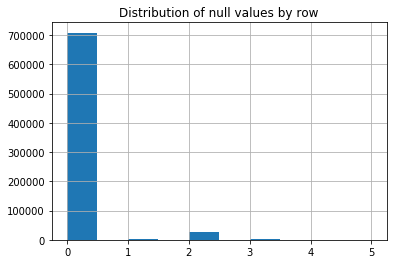

In [40]:
near_complete.isnull().sum(axis = 1).hist()
plt.title("Distribution of null values by row")
plt.show()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
near_complete.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
for column in near_complete.columns:
    near_complete[column] = near_complete[column].replace(np.nan, near_complete[column].mode()[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's take a look at `near_complete` now after the imputation. 

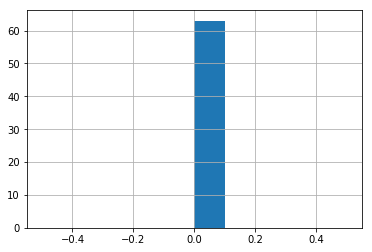

In [43]:
near_complete.isnull().sum().hist()
plt.show()

We can see now that we have succesfully imputed all the null values by using the mode of each column in their place. You could of course use other techniques, including building specific models to impute the values based on other values, but using the mode will suffice on this occasion. 

### Scaling `near_complete`

In [44]:
scaler = StandardScaler()
near_columns = near_complete.columns

# Take a look at some of the column names to check
print(list(near_columns)[:5])

['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST']


In [45]:
# Scale the data
near_scaled = scaler.fit_transform(near_complete)

# Rebuild the data into a DataFrame object as scaling removes the column names 
near_complete = pd.DataFrame(near_scaled, columns = near_columns)

In [46]:
# View the first few rows of the data
near_complete.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,ARBEIT,ORTSGR_KLS9,RELAT_AB,is_mainstream,decade,household,life_status,is_location_east
0,-0.573233,-1.683129,0.956848,0.980106,-1.469694,1.527827,-1.047587,1.463768,1.005949,1.305608,...,-0.789393,0.193387,-0.189511,-0.149366,0.665909,0.531536,1.109647,1.157249,-1.245977,-0.519569
1,-0.573233,0.164924,0.956848,-0.321812,-1.469694,0.858648,-1.773232,-0.567608,0.286069,1.305608,...,0.296768,-0.450641,-0.189511,-0.149366,-0.808346,-1.881342,1.109647,-0.888188,0.759904,-0.519569
2,1.856979,1.088950,0.956848,-0.972771,0.707135,-0.479711,1.129349,-0.567608,-1.153690,-0.864353,...,0.296768,-1.094669,-1.195774,-1.020539,-0.071218,0.531536,-0.250433,-1.570001,-0.577350,-0.519569
3,-0.573233,0.164924,-1.045098,0.980106,0.707135,0.189468,0.403703,-1.244734,0.286069,-0.864353,...,1.382928,1.481443,0.816752,0.286221,1.403037,0.531536,-0.250433,0.475437,0.091277,-0.519569
4,2.667050,-1.683129,0.956848,-0.972771,-0.018474,-1.148891,1.129349,-0.567608,-0.433810,1.305608,...,0.296768,-1.094669,-1.195774,-1.020539,-0.071218,0.531536,-1.610513,1.157249,0.759904,-0.519569


We can see that we appear to have scaled the data correctly, but we can compare the means and standard deviations of all columns as such:

### Discussion 2.1: Apply Feature Scaling

For feature scaling to occur without having any issues, you have to impute those `nan` values, but once that was done, I chose to use a standard scaler to make sure that no one feature had algorithmic power over another based on scale. I simply chose to impute the values using the mode for each column rather than using a imputer, or building a model that imputes the values for you based on other values for that observation. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# How many components do we want to use? 
full_pca = PCA()
pca_results = full_pca.fit_transform(near_complete)

In [48]:
def plot_pca_explained_variance(pca):
    n_components = len(pca.explained_variance_ratio_)
    x = np.arange(n_components)
    each_component = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(each_component)
    
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(111)
    ax.bar(x, each_component)
    ax.plot(x, cumulative_variance, color = '#f39c12')
    ax.set_xlabel('PCA component')
    ax.set_ylabel('Variance Explained')
    plt.show()

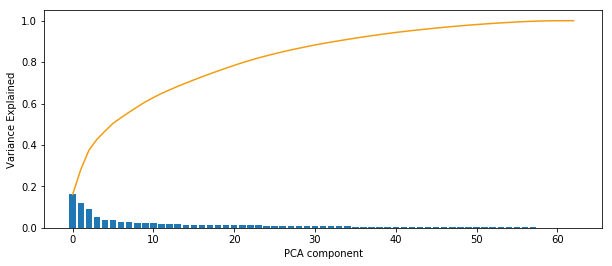

In [49]:
plot_pca_explained_variance(full_pca)

Note that when we are using `n_components` = `n_features` then we are going to reach the full 100% variance explained.  

We can see the values returned by the pca by accessing the attribute `explained_variance_ratio_`. 

In [50]:
# Investigate the variance accounted for by each principal component.
full_pca.explained_variance_ratio_

array([  1.61081442e-01,   1.19750100e-01,   9.29613073e-02,
         5.33830356e-02,   3.96723562e-02,   3.77497475e-02,
         2.75613062e-02,   2.62677018e-02,   2.53196933e-02,
         2.44818512e-02,   2.08873505e-02,   1.97297119e-02,
         1.71956051e-02,   1.67963839e-02,   1.58724450e-02,
         1.54101046e-02,   1.49839769e-02,   1.43548733e-02,
         1.39396413e-02,   1.37828256e-02,   1.32635958e-02,
         1.26815305e-02,   1.19042964e-02,   1.15395764e-02,
         1.00237488e-02,   9.86031040e-03,   9.54519233e-03,
         8.80781380e-03,   8.23873525e-03,   7.95794873e-03,
         7.82183734e-03,   7.23568863e-03,   6.81893041e-03,
         6.48673421e-03,   6.27826264e-03,   6.19488029e-03,
         5.90809100e-03,   5.67062299e-03,   5.59697436e-03,
         5.31775162e-03,   4.90144106e-03,   4.62274176e-03,
         4.42977148e-03,   4.24005705e-03,   4.04922043e-03,
         3.96435175e-03,   3.73222247e-03,   3.56565629e-03,
         3.38466737e-03,

We don't want to take 63 components through, because that isn't actually reducing the dimensions of the data! We want to make a decision that allows us to find which value for `n_components` is going to combine the best balance between variance_explained and reduction in dimensions. 

In [51]:
cumulative = np.cumsum(full_pca.explained_variance_ratio_)
for idx, variance in enumerate(cumulative):
    if variance > 0.8:
        print('{} : {}'.format(idx + 1, variance*100))

23 : 80.90308823966971
24 : 82.0570458757393
25 : 83.05942076041659
26 : 84.04545180057215
27 : 84.99997103359587
28 : 85.88075241313142
29 : 86.70462593820324
30 : 87.50042081154903
31 : 88.28260454586443
32 : 89.0061734084233
33 : 89.6880664492446
34 : 90.33673986986976
35 : 90.96456613345781
36 : 91.58405416247679
37 : 92.174863262299
38 : 92.74192556103647
39 : 93.30162299686737
40 : 93.83339815854647
41 : 94.32354226441932
42 : 94.78581644081063
43 : 95.22879358883392
44 : 95.65279929373527
45 : 96.0577213368807
46 : 96.45415651198445
47 : 96.82737875853724
48 : 97.18394438711441
49 : 97.52241112431649
50 : 97.85484955262869
51 : 98.15047752330534
52 : 98.42856333626824
53 : 98.69731230626526
54 : 98.9502494888925
55 : 99.17862954924908
56 : 99.39054860808963
57 : 99.58320673308926
58 : 99.7425227138503
59 : 99.87004110384599
60 : 99.96816539950856
61 : 99.98880406116938
62 : 100.0
63 : 100.0


In [52]:
for i, diff in enumerate(np.diff(cumulative * 100)):
    print('{} : {}'.format(i, diff))

0 : 11.97501002606381
1 : 9.296130730206272
2 : 5.338303557684782
3 : 3.967235621680331
4 : 3.7749747478629203
5 : 2.75613061581614
6 : 2.6267701816527023
7 : 2.5319693279157747
8 : 2.4481851242654713
9 : 2.0887350538662375
10 : 1.972971188829753
11 : 1.719560512708739
12 : 1.6796383948466342
13 : 1.5872444959887844
14 : 1.541010463763314
15 : 1.4983976886688737
16 : 1.435487334964236
17 : 1.3939641261724347
18 : 1.3782825604444326
19 : 1.3263595820663738
20 : 1.2681530538138048
21 : 1.1904296363153861
22 : 1.1539576360695918
23 : 1.0023748846772804
24 : 0.9860310401555665
25 : 0.9545192330237171
26 : 0.8807813795355486
27 : 0.8238735250718179
28 : 0.7957948733457982
29 : 0.7821837343153959
30 : 0.7235688625588637
31 : 0.6818930408213077
32 : 0.6486734206251583
33 : 0.627826263588048
34 : 0.6194880290189815
35 : 0.5908090998222093
36 : 0.5670622987374685
37 : 0.5596974358308984
38 : 0.5317751616791071
39 : 0.49014410587284374
40 : 0.4622741763913183
41 : 0.4429771480232887
42 : 0.42400

In [53]:
pca = PCA(30)
pca_results = pca.fit_transform(near_complete)

### Discussion 2.2: Perform Dimensionality Reduction

You want to go through and look at the cumulative variance explained and select a n_pca_components that suits a large percentage of the variance explained. 

Looking at both the cumuluative total variance explained, and the gain between each component, I think that 30 is good cutoff point, as below that point each component adds less than 0.75% variance explained. There could be an argument for cutting off sooner to avoid diminishing returns, but 30 components provides 88% variance explained as well so I think that the balance is right. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

#### Map the weights for the first PCA component 

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

df = pd.DataFrame(pca.components_[0])
df.index = near_complete.columns
df.columns = ['score_1']
df = df.sort_values(by='score_1')
df

,score_1
FINANZ_VORSORGER,-0.239605
ALTERSKATEGORIE_GROB,-0.237770
FINANZ_MINIMALIST,-0.231074
SEMIO_ERL,-0.181669
LP_STATUS_GROB,-0.171007
SEMIO_LUST,-0.168966
AGER_TYP,-0.163844
LP_STATUS_FEIN,-0.157111
FINANZTYP,-0.133157
RETOURTYP_BK_S,-0.124647


#### Map the weights for the second PCA component 

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df = pd.DataFrame(pca.components_[1])
df.index = near_complete.columns
df.columns = ['score_2']
df = df.sort_values(by='score_2')
df

,score_2
LP_STATUS_FEIN,-0.226132
LP_STATUS_GROB,-0.217862
SEMIO_KULT,-0.190823
SEMIO_VERT,-0.190207
ONLINE_AFFINITAET,-0.171106
FINANZ_MINIMALIST,-0.167977
SEMIO_FAM,-0.159297
LP_FAMILIE_GROB,-0.149894
ANZ_PERSONEN,-0.148827
LP_FAMILIE_FEIN,-0.148748


#### Map the weights for the third PCA component 

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df = pd.DataFrame(pca.components_[2])
df.index = near_complete.columns
df.columns = ['score_3']
df = df.sort_values(by='score_3')
df

,score_3
ANREDE_KZ,-0.325227
SEMIO_KAEM,-0.280105
SEMIO_DOM,-0.273520
SEMIO_KRIT,-0.217206
SEMIO_RAT,-0.195261
FINANZ_ANLEGER,-0.187854
SEMIO_ERL,-0.150223
ONLINE_AFFINITAET,-0.134442
INNENSTADT,-0.120764
KONSUMNAEHE,-0.115175


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

If two values are the same sign (positive or negative) then we can say that they are correlated, i.e. if one goes up then so does the other. In the third component we can see that `SEMIO_KULT`, `SEMIO_FAM`, `SEMIO_SOZ`, `SEMIO_VERT` all seem to be correlated in that component, in that when one goes up then so does the other.  

If they have opposing signs, then they are oppositely correlated; as one goes up then the other goes down. In the first component: `FINANZ_VORSORGER` and `FINANZ_SPARER` appear to be negatively correlated as the signs differ. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
def calculate_clusters_score_abs(X, centers = 3):
    # Create a KMeans instance with the number of relevant clusters
    kmeans = KMeans(n_clusters = centers)
    # Fit the data
    model = kmeans.fit(X)
    # Calculate and return the score, including making the output positive using numpy
    return np.abs(model.score(X))

In [58]:
def plot_sse(X, k_start = 1, k_end = 10, k_step = 2, highlight = False):
    scores = []
    clusters = range(k_start, k_end + 1, k_step)
    
    for k in clusters:
        scores.append(calculate_clusters_score_abs(X, k))
        
    plt.plot(clusters, scores)
    
    if highlight != False:
        plt.scatter(highlight, scores[highlight - 1],marker = 'o', facecolors='none', edgecolors='r')
        
    # Show the plot 
    plt.show()

In [59]:
scores = []
for i in range(2,21,2):
    scores.append(calculate_clusters_score_abs(pca_results, i))
    print('Score with {} clusters complete.'.format(i))

Score with 2 clusters complete.
Score with 4 clusters complete.
Score with 6 clusters complete.
Score with 8 clusters complete.
Score with 10 clusters complete.
Score with 12 clusters complete.
Score with 14 clusters complete.
Score with 16 clusters complete.
Score with 18 clusters complete.
Score with 20 clusters complete.


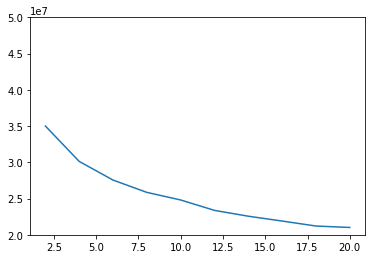

In [66]:
plt.plot(range(2,21,2), scores)
plt.ylim(2e7,5e7)
plt.show()

If we have a look at the plot that I've made showing the scores across number of clusters, then we can see that the score is already starting to plateau and we don't need to fit the `KMeans` model to every level to find out which number of clusters might be appropriate for us in this situation. I think that a good value for the number of clusters, is 10. 

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_chosen = 10
kmeans_model = KMeans(n_chosen)
kmeans_model.fit(pca_results)
predict_general = kmeans_model.predict(pca_results)

Having decided on the number of clusters, we can use that to make a prediction about the cluster of each observation in the original near_complete pca results. 

### Discussion 3.1: Apply Clustering to General Population

Running the `KMeans` was very intensive, and I don't think we are going to find a drastic drop after 10 clusters. I think we have found the elbow in this first pass and will proceed with 10 clusters. This will provide a clustering that differentiates them significantly, but doesn't overfit them into very specific groups of customers. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

We want to apply all the steps that we have done previously to this customers demographics data. They include:
* Cleaning using our function `clean_data` 
* Scaling using the `scaler` that is fitted on the `near_complete` data for comparison
* Running pca using the same `pca` object 
* Predict using our `KMeans` model 

In [63]:
clean_customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_

In [68]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
# This might have been better if this had been placed inside the clean_data function
for column in clean_customers.columns:
    clean_customers[column] = clean_customers[column].replace(np.nan, clean_customers[column].mode()[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_columns = clean_customers.columns

# Use the same scaler as fitted with the near_complete data 
customers_scaled = scaler.transform(clean_customers.as_matrix())

# Rebuild the data into a DataFrame object as scaling removes the column names 
customers_scaled = pd.DataFrame(customers_scaled, columns = customer_columns)
customers_scaled.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,ARBEIT,ORTSGR_KLS9,RELAT_AB,is_mainstream,decade,household,life_status,is_location_east
0,1.856979,1.088950,-1.045098,0.980106,1.432745,-1.148891,1.129349,-1.244734,-0.433810,-0.864353,...,0.296768,0.193387,-2.202038,-1.456125,-1.545473,-1.881342,-1.610513,-1.570001,0.091277,-0.519569
1,-0.573233,1.088950,0.956848,-0.972771,1.432745,-1.148891,1.129349,-1.244734,1.005949,0.582287,...,-0.789393,-1.094669,-0.189511,-0.149366,-0.071218,-1.881342,-1.610513,-0.206376,0.759904,-0.519569
2,1.046908,1.088950,-1.045098,-0.972771,1.432745,-1.148891,1.129349,-0.567608,-1.153690,-0.864353,...,0.296768,-0.450641,-2.202038,-1.020539,-1.545473,0.531536,-2.290553,-0.888188,0.759904,-0.519569
3,-0.573233,0.164924,-1.045098,1.631066,-0.018474,-1.148891,0.403703,0.786643,1.725828,-0.864353,...,-0.789393,1.481443,-0.189511,-0.149366,-1.545473,0.531536,-0.250433,0.475437,-1.245977,-0.519569
4,1.046908,0.164924,-1.045098,0.329147,1.432745,-1.148891,1.129349,-1.244734,-0.433810,-0.141033,...,0.296768,0.193387,-0.189511,0.721807,1.403037,-1.881342,-1.610513,-0.206376,0.759904,-0.519569


In [70]:
customers_pca = pca.transform(customers_scaled)

In [71]:
customers_prediction = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_proportion = []
customers_proportion = []
x = [i + 1 for i in range(10)]

for i in x:
    general_proportion.append((predict_general == i).sum()/len(predict_general))
    customers_proportion.append((customers_prediction == i).sum()/len(customers_prediction))

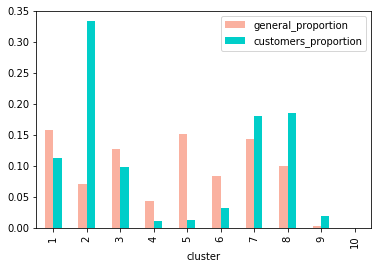

In [80]:
d = pd.DataFrame({'cluster' : x, 'general_proportion' : general_proportion, 'customers_proportion' : customers_proportion})

d.plot(x = 'cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', color = ['#fab1a0', '#00cec9'])
plt.show()

Note that cluster 2 is vastly overrepresented in the customer data compared to the general population. 

In [113]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_2_rows_customers = np.where(customers_prediction == 2)[0]
cluster_2_rows_general = np.where(predict_general == 2)[0]

customers_undo_pca = pca.inverse_transform(customers_pca[cluster_2_rows_customers])
customers_unscaled = scaler.inverse_transform(customers_undo_pca).round()

df = pd.DataFrame(customers_unscaled, columns = customer_columns)

In [128]:
df.mode()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,ARBEIT,ORTSGR_KLS9,RELAT_AB,is_mainstream,decade,household,life_status,is_location_east
0,1.0,4.0,1.0,2.0,5.0,1.0,5.0,1.0,2.0,2.0,...,4.0,3.0,3.0,5.0,3.0,-0.0,3.0,2.0,4.0,-0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that cluster 5 is vastly underrepresented in the customer data compared to the general population. 

In [124]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_5_rows_customers = np.where(customers_prediction == 5)[0]
cluster_5_rows_general = np.where(predict_general == 5)[0]

customers_undo_pca_2 = pca.inverse_transform(customers_pca[cluster_5_rows_customers])
customers_unscaled_2 = scaler.inverse_transform(customers_undo_pca_2).round()

df_2 = pd.DataFrame(customers_unscaled_2, columns = customer_columns)

In [127]:
df_2.mode()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,ARBEIT,ORTSGR_KLS9,RELAT_AB,is_mainstream,decade,household,life_status,is_location_east
0,-1.0,1.0,2.0,4.0,1.0,4.0,2.0,4.0,4.0,4.0,...,4.0,4.0,4.0,8.0,4.0,1.0,6.0,4.0,1.0,-0.0


Cluster 5 tends to have people that have a low financial interest, lower age (under the age of 30) and are generally female, whereas Cluster 2 are made up of more older male investors.  

Looking towards the end of the `head` calls, we can see that cluster 5 is made of mainyl singles, whereas Cluster 2 has a life status of 4 mostly which represents more mature couples that perhaps have a greater interested in things such as investing. 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)  

It seems that the mail-order company doesn't appeal to women with minimal financial interest as much as it does mean that are interested in investing and are perhaps interested, therefore, in products that are related to money; on the other hand this might mean that they have more money to spend. This is where further knowledge of those particular customer's behaviour might allow further insight into the ways that this could be applied at a business level. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.